- read csv
- eda
- cleaning
- preprocessing
- eda

- training arima
- training linear regression
- training lstm

- evaluation

# Library

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import tensorflow as tf
# import warnings
# warnings.filterwarnings('ignore')  # Uncomment if you want to suppress warnings

## Read CSV

In [170]:
#Load data dari CSV 
file_path = 'fixed_data_new.csv'  # ganti dengan path yang sesuai
df = pd.read_csv(file_path) 

# Jumlah Produk Terjual (Qty)

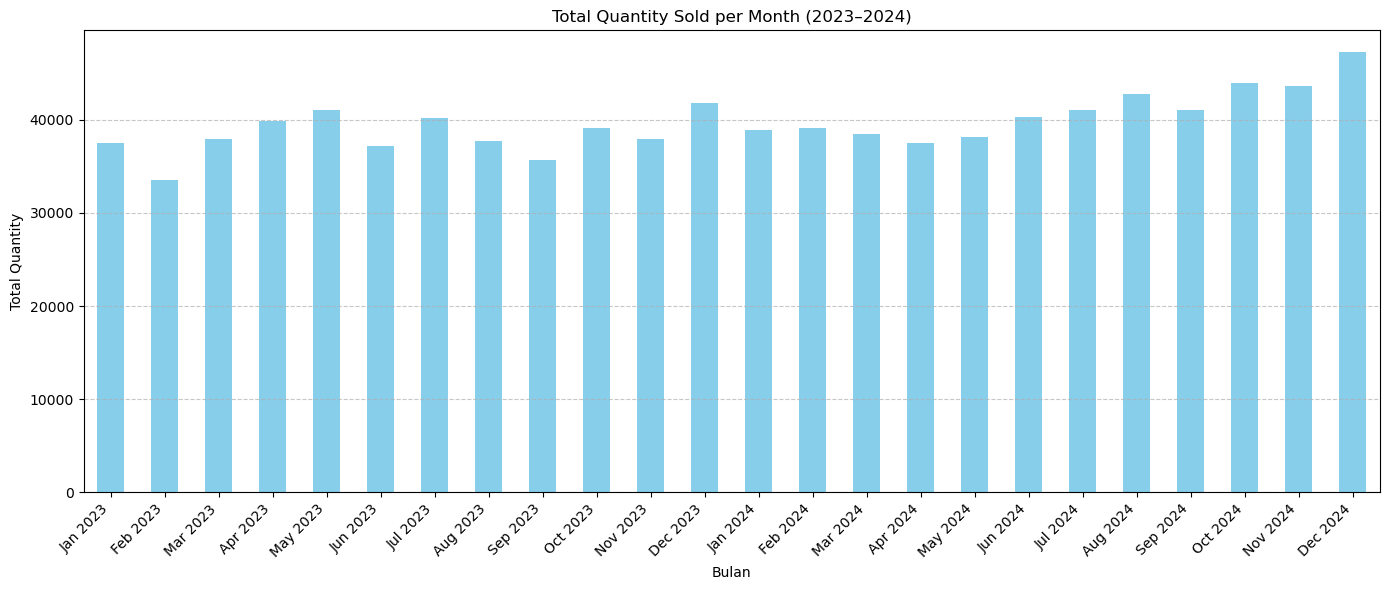

In [17]:
# Buat kolom label bulan-tahun misalnya 'Jan 2023'
df['Month_Year'] = df['order_date'].dt.strftime('%b %Y')  # format Inggris: Jan 2023, Feb 2023

# Group by Month_Year dan jumlahkan qty
qty_per_month = df.groupby('Month_Year')['qty'].sum()

# Sort berdasarkan waktu sebenarnya (bukan alfabet label)
df['order_month'] = df['order_date'].dt.to_period('M')
qty_per_month = df.groupby('order_month')['qty'].sum()
qty_per_month.index = qty_per_month.index.to_timestamp()
qty_per_month.index.name = 'Month'

plt.figure(figsize=(14, 6))
qty_per_month.plot(kind='bar', color='skyblue')
plt.title('Total Quantity Sold per Month (2023–2024)')
plt.xlabel('Bulan')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45, ha='right')

# Format x-axis tick labels as 'Jan 2023', 'Feb 2023', etc.
plt.gca().set_xticklabels([x.strftime('%b %Y') for x in qty_per_month.index])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Jumlah pemesanan (ID)

Number of unique IDs: 512463


C:\Users\Valentino Marcell\AppData\Local\Temp\ipykernel_30072\3452499791.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['qty'] = pd.to_numeric(df['qty'], errors='coerce')


Top ID based on quantity sold:
id
150e35f8-2e8b-4cc6-843f-fffc6624b53e    100
Name: qty, dtype: int64


C:\Users\Valentino Marcell\AppData\Local\Temp\ipykernel_30072\3452499791.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


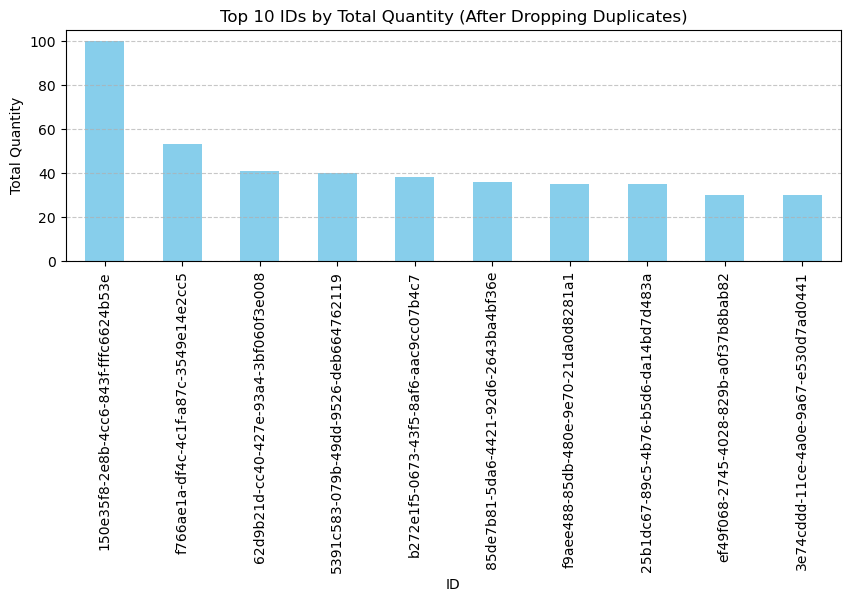

In [18]:
# drop duplicate 'id', only keep the first occurrence
df = df.drop_duplicates(subset='id')

# count the number of unique 'id'
unique_id_count = df['id'].nunique()
print(f"Number of unique IDs: {unique_id_count}")

# make sure 'qty' column contains numbers
df['qty'] = pd.to_numeric(df['qty'], errors='coerce')

# group data by 'id' and sum 'qty'
qty_per_id = df.groupby('id')['qty'].sum().sort_values(ascending=False)

# take top 1 'id' based on 'qty'
top_id = qty_per_id.head(1)
print("Top ID based on quantity sold:")
print(top_id)

# untuk visualisasi: ambil 10 ID teratas berdasarkan jumlah 'qty'
top_10_ids = qty_per_id.head(10)

# Plotting
plt.figure(figsize=(10, 3))
# membuat diagram batang (bar chart) dari 10 ID teratas
top_10_ids.plot(kind='bar', color='skyblue')
plt.title('Top 10 IDs by Total Quantity (After Dropping Duplicates)')
plt.xlabel('ID')
plt.ylabel('Total Quantity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Cleaning

In [171]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['Final Price'] = pd.to_numeric(df['Final Price'], errors='coerce')

# --- Handle missing value ---
df['Final Price'].fillna(df['Final Price'].median(), inplace=True)
df['order_date'].fillna(method='ffill', inplace=True)

In [172]:
#outlier detection and removal
Q1 = df['Final Price'].quantile(0.25)
Q3 = df['Final Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Final Price'] < lower_bound) | (df['Final Price'] > upper_bound)]
print(f"\n🔎 Number of outliers to drop: {len(outliers)}")

# Drop outliers
df = df[(df['Final Price'] >= lower_bound) & (df['Final Price'] <= upper_bound)]


🔎 Number of outliers to drop: 108732


In [173]:
# Check for invalid values
print("Negative values in Final Price:", (df['Final Price'] < 0).sum())
print("Zero values in Final Price:", (df['Final Price'] == 0).sum())

# Group by month and aggregate Final Price
monthly_df = (
    df.groupby(df['order_date'].dt.to_period('M'))['Final Price']
    .sum()
    .reset_index()
)
monthly_df['order_date'] = monthly_df['order_date'].dt.to_timestamp()
monthly_df.columns = ['Month', 'Final Price']
monthly_df.set_index('Month', inplace=True)

# Fill missing months with 0
all_months = pd.date_range(
    start=df['order_date'].min().to_period('M').to_timestamp(),
    end=df['order_date'].max().to_period('M').to_timestamp(),
    freq='MS'
)
monthly_df = monthly_df.reindex(all_months, fill_value=0)
monthly_df.index.name = 'Month'  # Proper index name

# Final Output
print("\nMonthly Aggregated Data (Outliers Removed):")
print(monthly_df)
print("Data historis terakhir:", monthly_df.index[-1].strftime('%B %Y'))


Negative values in Final Price: 4
Zero values in Final Price: 0

Monthly Aggregated Data (Outliers Removed):
            Final Price
Month                  
2023-01-01   1786500717
2023-02-01   1591295661
2023-03-01   1669167243
2023-04-01   1742735165
2023-05-01   1855971510
2023-06-01   1593148326
2023-07-01   1678504728
2023-08-01   1524228575
2023-09-01   1444876752
2023-10-01   1524130177
2023-11-01   1435799335
2023-12-01   1518078216
2024-01-01   1439972384
2024-02-01   1423125157
2024-03-01   1575378135
2024-04-01   1539700295
2024-05-01   1560085176
2024-06-01   1616441953
2024-07-01   1654644398
2024-08-01   1721881919
2024-09-01   1609832844
2024-10-01   1669777462
2024-11-01   1669600563
2024-12-01   1779325625
Data historis terakhir: December 2024


## Visualisasi

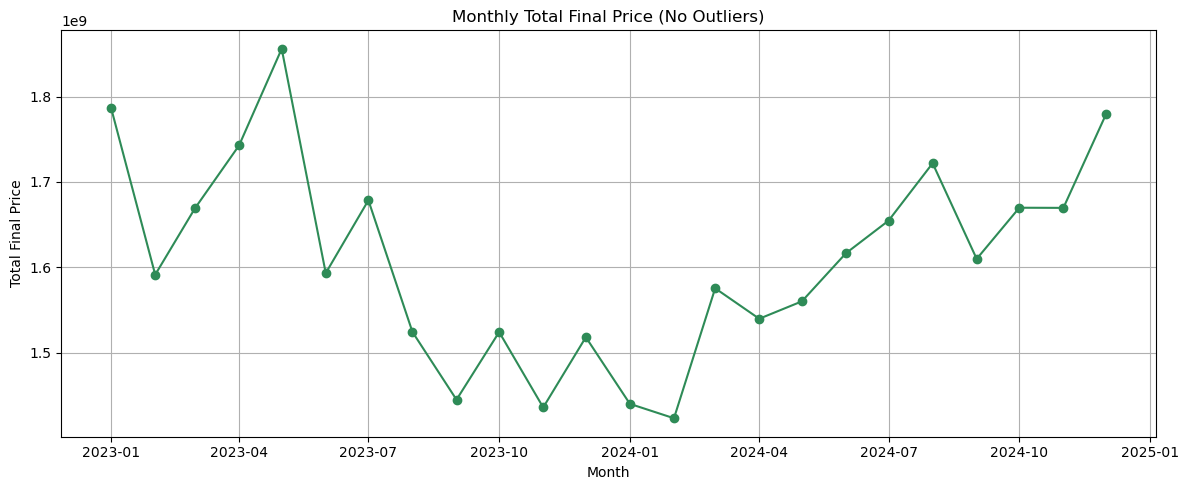

In [174]:
plt.figure(figsize=(12, 5))
plt.plot(monthly_df.index, monthly_df['Final Price'], marker='o', color='seagreen')
plt.title('Monthly Total Final Price (No Outliers)')
plt.xlabel('Month')
plt.ylabel('Total Final Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# ARIMA

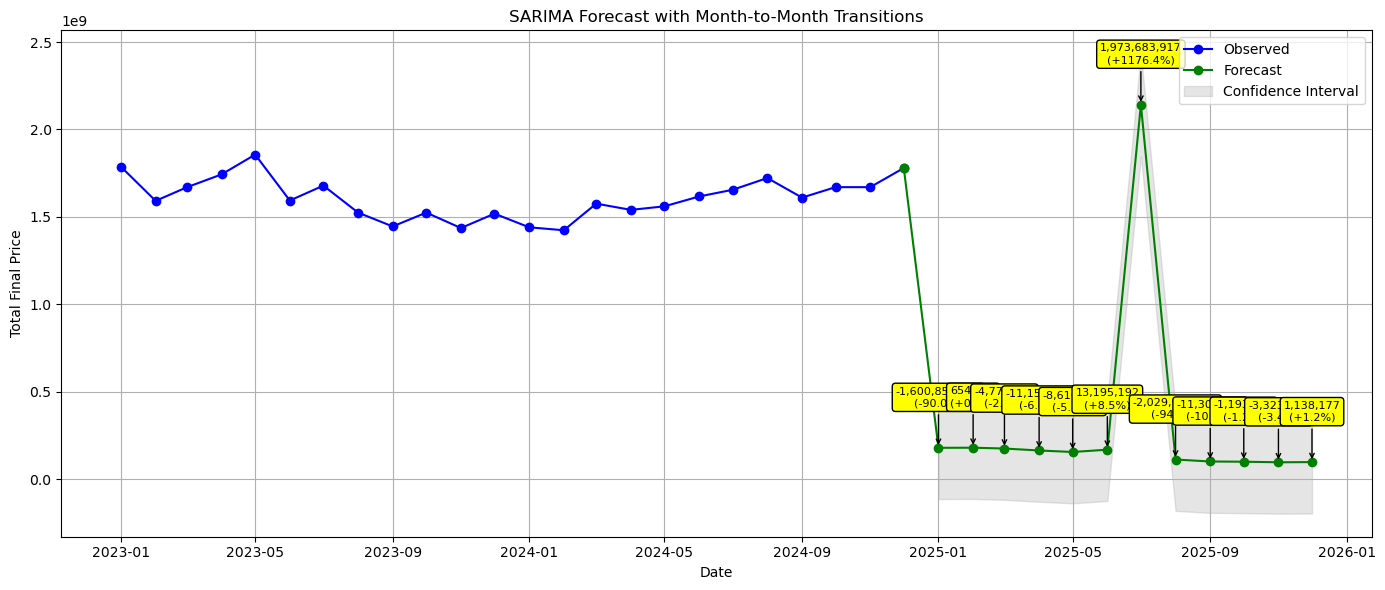

In [168]:
# forecast untuk 12 bulan ke depan
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean # Prediksi nilai rata-rata
forecast_ci = forecast.conf_int()

# tentukan indeks waktu untuk prediksi
forecast_index = pd.date_range(start=monthly_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
# forecast_index = pd.date_range(start=monthly_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# gabungkan observed + forecast untuk plotting
last_obs_date = monthly_df.index[-1]
last_obs_value = monthly_df.iloc[-1]['Final Price']
continuous_dates = [last_obs_date] + list(forecast_index)
continuous_values = [last_obs_value] + list(forecast_mean)

# plot hasil
plt.figure(figsize=(14, 6))
plt.plot(monthly_df.index, monthly_df['Final Price'], label='Observed', color='blue', marker='o')
plt.plot(continuous_dates, continuous_values, label='Forecast', color='green', marker='o')

# Tambahkan Confidence Interval ke plot
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Interval')

# Anotasi perbedaan forecast per bulan
for i in range(1, len(continuous_values)):
    prev = continuous_values[i-1] # Nilai bulan sebelumnya
    curr = continuous_values[i] # Nilai bulan saat ini (prediksi)
    date = continuous_dates[i] # Tanggal prediksi
    diff = curr - prev
    pct = (diff / prev) * 100 if prev != 0 else 0
    label = f"{diff:,.0f}\n({pct:+.1f}%)"
    plt.annotate(label, xy=(date, curr), xytext=(0, 30), textcoords='offset points',
                 ha='center', fontsize=8, bbox=dict(boxstyle="round", facecolor='yellow'),
                 arrowprops=dict(arrowstyle='->', color='black'))

plt.title("SARIMA Forecast with Month-to-Month Transitions")
plt.xlabel("Date")
plt.ylabel("Total Final Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

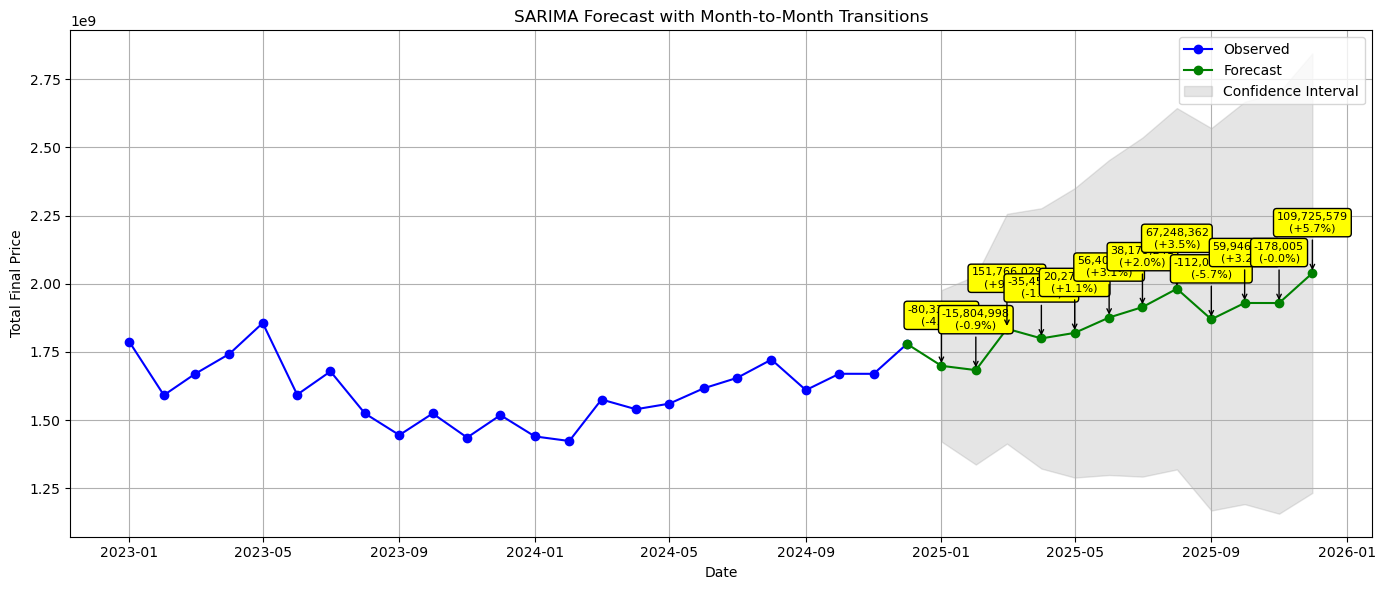

In [175]:
# Fit SARIMA model on monthly aggregated data
model = sm.tsa.statespace.SARIMAX(monthly_df['Final Price'],
                                  order=(1, 1, 1),  # parameter ARIMA
                                  seasonal_order=(1, 1, 1, 12),  # parameter musiman
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# forecast untuk 12 bulan ke depan
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean # Prediksi nilai rata-rata
forecast_ci = forecast.conf_int()

# tentukan indeks waktu untuk prediksi
forecast_index = pd.date_range(start=monthly_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# gabungkan observed + forecast untuk plotting
last_obs_date = monthly_df.index[-1]
last_obs_value = monthly_df.iloc[-1]['Final Price']
continuous_dates = [last_obs_date] + list(forecast_index)
continuous_values = [last_obs_value] + list(forecast_mean)

# plot hasil
plt.figure(figsize=(14, 6))
plt.plot(monthly_df.index, monthly_df['Final Price'], label='Observed', color='blue', marker='o')
plt.plot(continuous_dates, continuous_values, label='Forecast', color='green', marker='o')

# Tambahkan Confidence Interval ke plot
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Interval')

# Anotasi perbedaan forecast per bulan
for i in range(1, len(continuous_values)):
    prev = continuous_values[i-1] # Nilai bulan sebelumnya
    curr = continuous_values[i] # Nilai bulan saat ini (prediksi)
    date = continuous_dates[i] # Tanggal prediksi
    diff = curr - prev
    pct = (diff / prev) * 100 if prev != 0 else 0
    label = f"{diff:,.0f}\n({pct:+.1f}%)"
    plt.annotate(label, xy=(date, curr), xytext=(0, 30), textcoords='offset points',
                 ha='center', fontsize=8, bbox=dict(boxstyle="round", facecolor='yellow'),
                 arrowprops=dict(arrowstyle='->', color='black'))

plt.title("SARIMA Forecast with Month-to-Month Transitions")
plt.xlabel("Date")
plt.ylabel("Total Final Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ARIMA(70% train and 30% test)

In [176]:
df = df.head(100000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 46641.4389
MSE: 3403843089.2838
RMSE: 58342.4639
MAPE: 121.85%
R²: -0.0000


In [277]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 86485.0323
MSE: 24485477701.9190
RMSE: 156478.3618
MAPE: 175.20%
R²: -0.0074


In [116]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 78953.7052
MSE: 13915814280.2337
RMSE: 117965.3096
MAPE: 187.60%
R²: -0.0169


In [4]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


C:\Users\Valentino Marcell\AppData\Local\Temp\ipykernel_11236\2736168465.py:2: DtypeWarning: Columns (8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fixed_data_new.csv')


MAE: 87395.5612
MSE: 15912700123.7536
RMSE: 126145.5513
MAPE: 347.08%
R²: -0.0298


In [117]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 79952.0692
MSE: 16578286669.0883
RMSE: 128756.6956
MAPE: 262.81%
R²: -0.0004


In [5]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


C:\Users\Valentino Marcell\AppData\Local\Temp\ipykernel_11236\3032658173.py:2: DtypeWarning: Columns (8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fixed_data_new.csv')


MAE: 164187.3114
MSE: 32756330837.7224
RMSE: 180987.1013
MAPE: 651.21%
R²: -1.2321


In [118]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 91897.7665
MSE: 14069794221.1586
RMSE: 118616.1634
MAPE: 287.98%
R²: -0.0406


In [119]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.7)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 78110.2720
MSE: 14697668846.4211
RMSE: 121233.9426
MAPE: 243.04%
R²: -0.0017


## ARIMA(60% train and 40% test)

In [120]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 97428.0504
MSE: 44375171872.7640
RMSE: 210654.1523
MAPE: 188.59%
R²: -0.0015


In [121]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 96115.6547
MSE: 27211635540.6785
RMSE: 164959.4967
MAPE: 228.89%
R²: -0.0049


In [122]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 81704.5845
MSE: 14288785978.2576
RMSE: 119535.7101
MAPE: 193.47%
R²: -0.0119


In [106]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 115603.1993
MSE: 19326699290.6396
RMSE: 139020.4995
MAPE: 510.86%
R²: -0.3039


In [123]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 96307.6187
MSE: 16602149938.8873
RMSE: 128849.3304
MAPE: 382.84%
R²: -0.0700


In [108]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 63149.0784
MSE: 16078931578.0118
RMSE: 126802.7270
MAPE: 117.51%
R²: -0.0948


In [109]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 139845.3362
MSE: 24409021402.1872
RMSE: 156233.8677
MAPE: 544.54%
R²: -0.7467


In [110]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)

# Select only the 'Harga Final' column
target = df['Final Price']

# Split the data into 70% train and 30% test
split_index = int(len(target) * 0.6)
train, test = target[:split_index], target[split_index:]

# Fit the ARIMA model (example: ARIMA(1,1,1) — you can change this)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the same length as the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100
r2 = r2_score(test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 64652.8831
MSE: 15628748556.3321
RMSE: 125014.9933
MAPE: 124.59%
R²: -0.0838


# Linear Regression

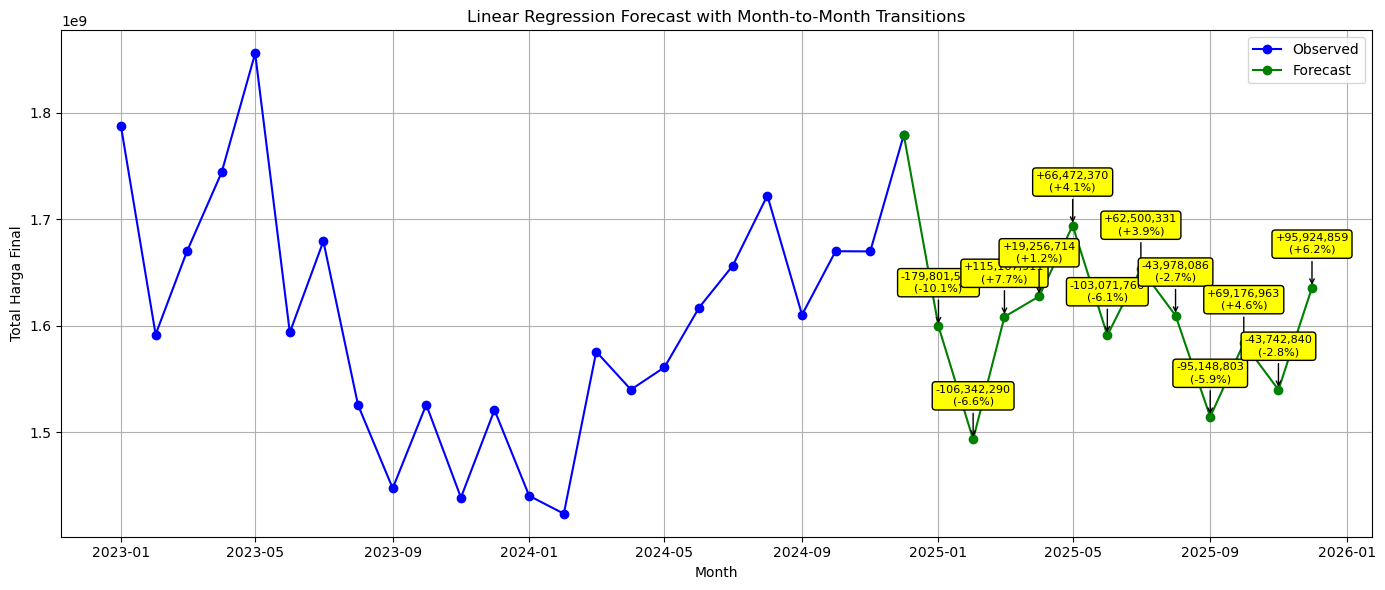

In [ ]:
#add trend waktu dan bulan
monthly_df['time'] = np.arange(len(monthly_df))
monthly_df['month'] = monthly_df.index.month
monthly_df = pd.get_dummies(monthly_df, columns=['month'], drop_first=True)

#menyiapkan fitur (X) dan target (y)
X = monthly_df.drop(columns='Final Price')
y = monthly_df['Final Price']

# Fit model
model = LinearRegression()
model.fit(X, y)

# forecast untuk 12 bulan ke depan
last_time = monthly_df['time'].iloc[-1]
future_times = np.arange(last_time + 1, last_time + 13)
future_index = pd.date_range(monthly_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
future_months = future_index.month

future_df = pd.DataFrame({'time': future_times, 'month': future_months}, index=future_index)
future_df = pd.get_dummies(future_df, columns=['month'], drop_first=True)

# add missing month columns with 0 values
for col in X.columns:
    if col not in future_df.columns:
        future_df[col] = 0
future_df = future_df[X.columns]

# predict future values
future_forecast = model.predict(future_df)

# Combine last observed point with forecast
last_observed_date = monthly_df.index[-1]
last_observed_value = y.iloc[-1]

fixed_data_newd_dates = [last_observed_date] + list(future_index)
fixed_data_newd_values = [last_observed_value] + list(future_forecast)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(monthly_df.index, y, label='Observed', marker='o', color='blue')
plt.plot(fixed_data_newd_dates, fixed_data_newd_values, label='Forecast', marker='o', color='green')

# Annotate forecast points
for i in range(1, len(fixed_data_newd_values)):
    prev = fixed_data_newd_values[i - 1]
    curr = fixed_data_newd_values[i]
    date = fixed_data_newd_dates[i]
    diff = curr - prev
    pct = (diff / prev) * 100 if prev != 0 else 0
    label = f"{'+' if diff >= 0 else ''}{diff:,.0f}\n({pct:+.1f}%)"
    plt.annotate(label, xy=(date, curr), xytext=(0, 25), textcoords='offset points',
                 ha='center', fontsize=8,
                 bbox=dict(boxstyle="round", facecolor='yellow'),
                 arrowprops=dict(arrowstyle='->', color='black'))

plt.title('Linear Regression Forecast with Month-to-Month Transitions')
plt.xlabel('Month')
plt.ylabel('Total Harga Final')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Linear Regression(70% train and 30% test)

In [128]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 97515.8366
MSE: 40528220567.0621
RMSE: 201316.2203
MAPE: 182.50%
R²: -0.0059


In [129]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 97154.2098
MSE: 24618164837.1716
RMSE: 156901.7681
MAPE: 243.96%
R²: -0.0129


In [130]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 93255.8922
MSE: 14019325917.3990
RMSE: 118403.2344
MAPE: 284.71%
R²: -0.0245


In [131]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 86323.2771
MSE: 15838731992.7392
RMSE: 125852.0242
MAPE: 339.75%
R²: -0.0250


In [132]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 75232.6824
MSE: 16703544932.3164
RMSE: 129242.1949
MAPE: 229.74%
R²: -0.0079


In [133]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 70984.7696
MSE: 15450434297.8878
RMSE: 124299.7759
MAPE: 153.70%
R²: -0.0528


In [144]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 70148.7345
MSE: 14081379844.1245
RMSE: 118664.9900
MAPE: 152.12%
R²: -0.0414


In [134]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (70% train, 30% test)
split_index = int(len(target) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 70788.0449
MSE: 14810633939.9322
RMSE: 121698.9480
MAPE: 189.34%
R²: -0.0094


## Linear Regression(60% train and 40% test)

In [135]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 96113.8025
MSE: 44457577654.0250
RMSE: 210849.6565
MAPE: 180.28%
R²: -0.0033


In [136]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 97757.3082
MSE: 27373598724.6386
RMSE: 165449.6864
MAPE: 238.83%
R²: -0.0109


In [137]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 96460.1706
MSE: 14646613135.5359
RMSE: 121023.1926
MAPE: 292.12%
R²: -0.0372


In [138]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 91150.0605
MSE: 15494804731.2969
RMSE: 124478.1295
MAPE: 348.32%
R²: -0.0397


In [139]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 81687.6647
MSE: 15640928367.2924
RMSE: 125063.6972
MAPE: 288.16%
R²: -0.0080


In [140]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 72903.1870
MSE: 15156571495.1469
RMSE: 123112.0282
MAPE: 189.52%
R²: -0.0285


In [141]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 68481.7727
MSE: 15128525626.9979
RMSE: 122998.0716
MAPE: 137.85%
R²: -0.0735


In [142]:
# Load the dataset
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)

# Select only the 'Final Price' column
target = df['Final Price'].reset_index(drop=True)

# Create a time-based feature (just index)
X = np.arange(len(target)).reshape(-1, 1)

# Split into train and test sets (60% train, 40% test)
split_index = int(len(target) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
forecast = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
r2 = r2_score(y_test, forecast)

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 67413.9855
MSE: 15312039221.2230
RMSE: 123741.8249
MAPE: 145.92%
R²: -0.0489


# LSTM

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1575
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1518
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1461
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1404
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1347
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1290
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1234
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1178
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1123
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1068
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1013
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0957
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0901
Epoch 14/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0843
Epoch 15/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0786
Epoch 16/25
1/1 ━━━━━━━━━━━━━━━━━━━━

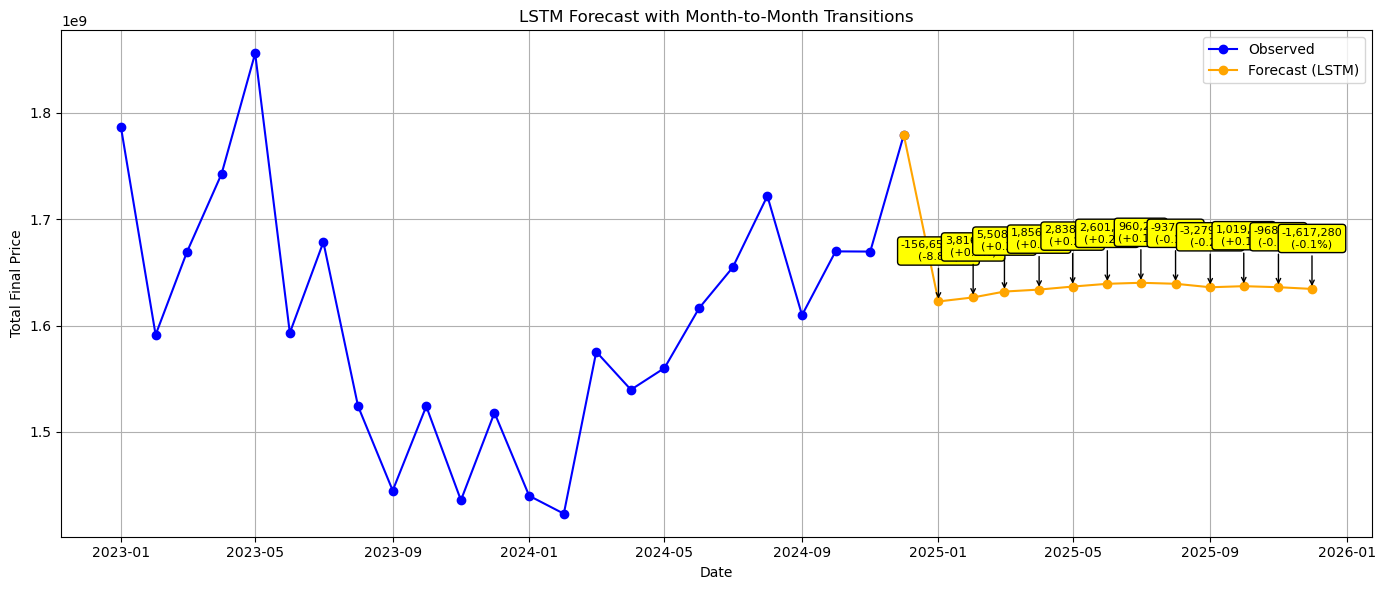

In [177]:
#Prepare the data
data = monthly_df['Final Price'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Sequence generator
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

# ==== 2. Split Data ====
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# ==== 3. Define LSTM ====
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# ==== 4. Train ====
model.fit(X_train, y_train, epochs=25, verbose=1)

# ==== 5. Forecast next 12 months ====
last_sequence = scaled_data[-seq_length:]
forecast_scaled = []
current_input = last_sequence.copy()

for _ in range(12):
    prediction = model.predict(current_input.reshape(1, seq_length, 1), verbose=0)
    forecast_scaled.append(prediction[0, 0])
    current_input = np.append(current_input[1:], [[prediction[0, 0]]], axis=0)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# ==== 6. Prepare for Plotting ====
forecast_index = pd.date_range(start=monthly_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
observed_index = monthly_df.index
observed_values = monthly_df['Final Price'].values

# Combine last actual with forecasts
last_obs_date = observed_index[-1]
last_obs_value = observed_values[-1]
continuous_dates = [last_obs_date] + list(forecast_index)
continuous_values = [last_obs_value] + list(forecast)

# ==== 7. Plot ====
plt.figure(figsize=(14, 6))
plt.plot(observed_index, observed_values, label='Observed', color='blue', marker='o')
plt.plot(continuous_dates, continuous_values, label='Forecast (LSTM)', color='orange', marker='o')

for i in range(1, len(continuous_values)):
    prev = continuous_values[i-1]
    curr = continuous_values[i]
    date = continuous_dates[i]
    diff = curr - prev
    pct = (diff / prev) * 100 if prev != 0 else 0
    label = f"{diff:,.0f}\n({pct:+.1f}%)"
    plt.annotate(label, xy=(date, curr), xytext=(0, 30), textcoords='offset points',
                 ha='center', fontsize=8, bbox=dict(boxstyle="round", facecolor='yellow'),
                 arrowprops=dict(arrowstyle='->', color='black'))

plt.title("LSTM Forecast with Month-to-Month Transitions")
plt.xlabel("Date")
plt.ylabel("Total Final Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM(70% train and 30% test)

In [194]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 9.8833e-05
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.8271e-05
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.4135e-04
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.1658e-05
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0593e-04
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE: 97076.6529
MSE: 37004815745.5602
RMSE: 192366.3581
MAPE: 193.65%
R²: 0.0816


In [195]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.5473e-04
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0546e-04
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0169e-04
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.1774e-04
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0383e-04
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3906e-04
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.5578e-05
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.5784e-04
Epoch 9/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.1529e-04
Epoch 10/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.2121e-05
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE: 95046.9694
MSE: 36802817327.6259
RMSE: 191840.6040
MAPE: 181.37%
R²: 0.0866


In [196]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.4022e-04
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.1047e-04
Epoch 3/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.0470e-05
Epoch 4/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.7653e-04
Epoch 5/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.1123e-04
Epoch 6/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.9737e-05
Epoch 7/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3805e-04
Epoch 8/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3206e-04
Epoch 9/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.5910e-05
Epoch 10/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.7252e-04
Epoch 11/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.4447e-05
Epoch 12/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8073e-04
Epoch 13/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.6967e-05
Epoch 14/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4

In [197]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.5564e-04
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.7394e-05
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0088e-04
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1343e-04
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0851e-04
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.8212e-04
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.6205e-04
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.2536e-04
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3832e-04
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.1475e-04
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.7834e-05
Epoch 12/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.6712e-05
Epoch 13/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1896e-04
Epoch 14/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4

In [228]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.6217e-05
Epoch 2/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.8279e-04
Epoch 3/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.1802e-05
Epoch 4/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0991e-04
Epoch 5/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.9888e-05
Epoch 6/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.1659e-05
Epoch 7/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.3737e-05
Epoch 8/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0057e-04
Epoch 9/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.4293e-04
Epoch 10/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6.6173e-05
Epoch 11/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0432e-04
Epoch 12/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.2161e-04
Epoch 13/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.3978e-04
Epoch 14/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5

In [199]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 8.5838e-05
Epoch 2/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.1198e-04
Epoch 3/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.1334e-04
Epoch 4/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 8.1492e-05
Epoch 5/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.0014e-05
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MAE: 86894.6927
MSE: 21175306828.6450
RMSE: 145517.3764
MAPE: 189.66%
R²: 0.1288


In [189]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 8.6608e-05
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 8.2671e-05
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 8.5890e-05
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 9.6725e-05
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.1080e-04
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.0889e-04
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.0223e-04
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 8.0222e-05
Epoch 9/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.0640e-04
Epoch 10/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 9.6047e-05
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MAE: 84626.5540
MSE: 21270302248.1188
RMSE: 145843.4169
MAPE: 177.05%
R²: 0.1249


In [190]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.0993e-04
Epoch 2/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 9.1154e-05
Epoch 3/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.3261e-04
Epoch 4/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 8.3100e-05
Epoch 5/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.0417e-04
Epoch 6/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.1592e-04
Epoch 7/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 9.0019e-05
Epoch 8/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.3064e-05
Epoch 9/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0755e-04
Epoch 10/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.2015e-04
Epoch 11/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0639e-04
Epoch 12/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0931e-04
Epoch 13/15
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.5774e-05
Epoch 14/15
2188/2188 ━━━━━━━━━━━━━━━━━

In [191]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 9.7118e-05
Epoch 2/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.4695e-04
Epoch 3/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 8.0579e-05
Epoch 4/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0145e-04
Epoch 5/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.5850e-05
Epoch 6/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0618e-04
Epoch 7/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.0791e-05
Epoch 8/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.1612e-04
Epoch 9/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0105e-04
Epoch 10/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 8.0432e-05
Epoch 11/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0914e-04
Epoch 12/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0973e-04
Epoch 13/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 8.0187e-05
Epoch 14/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s

In [192]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(200000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 8.8744e-05
Epoch 2/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0500e-04
Epoch 3/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 9.8180e-05
Epoch 4/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.2199e-04
Epoch 5/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8.4866e-05
Epoch 6/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.5839e-05
Epoch 7/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.2961e-04
Epoch 8/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.9589e-05
Epoch 9/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8.5831e-05
Epoch 10/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.1181e-04
Epoch 11/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 9.5415e-05
Epoch 12/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.5955e-05
Epoch 13/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.8110e-05
Epoch 14/25
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8

In [201]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 9.7997e-05
Epoch 2/5
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 7.4612e-05
Epoch 3/5
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 8.4756e-05
Epoch 4/5
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 1.1549e-04
Epoch 5/5
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 8.5527e-05
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
MAE: 77082.4467
MSE: 13332031093.3244
RMSE: 115464.4148
MAPE: 181.66%
R²: 0.0257


In [200]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 1.0864e-04
Epoch 2/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.7631e-05
Epoch 3/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 9.1924e-05
Epoch 4/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.7867e-05
Epoch 5/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.9772e-05
Epoch 6/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.9452e-05
Epoch 7/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 8.0943e-05
Epoch 8/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 8.7195e-05
Epoch 9/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.9501e-05
Epoch 10/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.1062e-04
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MAE: 79254.8085
MSE: 13172745664.4207
RMSE: 114772.5824
MAPE: 198.34%
R²: 0.0374


In [193]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 1.0519e-04
Epoch 2/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 8.3036e-05
Epoch 3/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.8727e-05
Epoch 4/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 8.2323e-05
Epoch 5/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 9.1779e-05
Epoch 6/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 8.6287e-05
Epoch 7/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 8.3469e-05
Epoch 8/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.3453e-04
Epoch 9/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 9.2969e-05
Epoch 10/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 7.3502e-05
Epoch 11/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.7578e-05
Epoch 12/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 7.2499e-05
Epoch 13/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 7.4821e-05
Epoch 14/15
3282/3282 ━━━━━━━━━━━━

In [202]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 9.7023e-05
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 8.0925e-05
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 9.3826e-05
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 8.4430e-05
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 7.5359e-05
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 7.0484e-05
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 9.7245e-05
Epoch 8/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 7.8232e-05
Epoch 9/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 7.1902e-05
Epoch 10/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 8.2294e-05
Epoch 11/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 8.6879e-05
Epoch 12/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 9.9520e-05
Epoch 13/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 8.2851e-05
Epoch 14/20
3282/3282 ━━━━━━━━━━━━

In [227]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(300000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 1.1114e-04
Epoch 2/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 9.4907e-05
Epoch 3/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 8.0761e-05
Epoch 4/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 7.9877e-05
Epoch 5/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 8.3899e-05
Epoch 6/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 1.0572e-04
Epoch 7/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 9.0882e-05
Epoch 8/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 8.1791e-05
Epoch 9/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 7.4403e-05
Epoch 10/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 9.1445e-05
Epoch 11/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 7.9654e-05
Epoch 12/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 8.6238e-05
Epoch 13/25
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 7.6036e-05
Epoch 14/25
3282/3282 ━━━━━━━━━━━━

In [226]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 7.4982e-05
Epoch 2/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 6.4483e-05
Epoch 3/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 7.9981e-05
Epoch 4/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 7.1879e-05
Epoch 5/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 7.4908e-05
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
MAE: 82886.7874
MSE: 14853106932.5350
RMSE: 121873.3233
MAPE: 324.38%
R²: 0.0388


In [225]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 7.3230e-05
Epoch 2/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 8.0994e-05
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 7.6041e-05
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 8.7258e-05
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 6.7420e-05
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 6.6114e-05
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 8.1460e-05
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 7.5516e-05
Epoch 9/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 6.8404e-05
Epoch 10/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 8.0551e-05
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
MAE: 79398.9736
MSE: 14755639834.2115
RMSE: 121472.7946
MAPE: 301.14%
R²: 0.0451


In [224]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 8.1150e-05
Epoch 2/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 8.8487e-05
Epoch 3/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 8.4388e-05
Epoch 4/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.8314e-05
Epoch 5/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 6.5368e-05
Epoch 6/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.9528e-05
Epoch 7/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.5036e-05
Epoch 8/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.4906e-05
Epoch 9/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.7642e-05
Epoch 10/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.2354e-05
Epoch 11/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 7.8358e-05
Epoch 12/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 7.8500e-05
Epoch 13/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.5283e-05
Epoch 14/15
4375/4375 ━━━━━━━━━━━━

In [203]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 7.5393e-05
Epoch 2/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 6.8447e-05
Epoch 3/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 7.6331e-05
Epoch 4/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 8.1777e-05
Epoch 5/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 7.2658e-05
Epoch 6/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 8.5186e-05
Epoch 7/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 7.0392e-05
Epoch 8/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 8.4296e-05
Epoch 9/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 7.0301e-05
Epoch 10/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 6.5099e-05
Epoch 11/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 8.1156e-05
Epoch 12/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 7.2741e-05
Epoch 13/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 7.0228e-05
Epoch 14/20
4375/4375 ━━━━━━━━━━━━

In [223]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(400000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 7.2995e-05
Epoch 2/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 7.2933e-05
Epoch 3/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.9808e-05
Epoch 4/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.9918e-05
Epoch 5/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.3468e-05
Epoch 6/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.7335e-05
Epoch 7/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 8.5229e-05
Epoch 8/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.8603e-05
Epoch 9/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.1673e-05
Epoch 10/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.4831e-05
Epoch 11/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.8936e-05
Epoch 12/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.8438e-05
Epoch 13/25
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 7.9727e-05
Epoch 14/25
4375/4375 ━━━━━━━━━━━━

In [222]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 6.8610e-05
Epoch 2/5
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.6733e-05
Epoch 3/5
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.5783e-05
Epoch 4/5
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.2620e-05
Epoch 5/5
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.5992e-05
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
MAE: 61312.3915
MSE: 15143735374.4875
RMSE: 123059.8853
MAPE: 150.41%
R²: 0.0862


In [221]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 7.1524e-05
Epoch 2/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.6744e-05
Epoch 3/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.7043e-05
Epoch 4/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.3129e-05
Epoch 5/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.6141e-05
Epoch 6/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.7193e-05
Epoch 7/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.2354e-05
Epoch 8/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.9900e-05
Epoch 9/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.7535e-05
Epoch 10/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.9207e-05
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
MAE: 78422.3382
MSE: 14945239238.1298
RMSE: 122250.7229
MAPE: 276.48%
R²: 0.0982


In [220]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 5.6635e-05
Epoch 2/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 6.4960e-05
Epoch 3/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.2140e-05
Epoch 4/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.6849e-05
Epoch 5/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.9031e-05
Epoch 6/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 7.4822e-05
Epoch 7/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 7.0704e-05
Epoch 8/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.2901e-05
Epoch 9/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 7.6966e-05
Epoch 10/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.3867e-05
Epoch 11/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 5.9672e-05
Epoch 12/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.9801e-05
Epoch 13/15
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.7480e-05
Epoch 14/15
5469/5469 ━━━━━━━━━━━━

In [204]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 6.1531e-05
Epoch 2/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.5857e-05
Epoch 3/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.1738e-05
Epoch 4/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.8993e-05
Epoch 5/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 5.9836e-05
Epoch 6/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 7.1266e-05
Epoch 7/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.0114e-05
Epoch 8/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 5.6578e-05
Epoch 9/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.2271e-05
Epoch 10/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 7.0244e-05
Epoch 11/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.0044e-05
Epoch 12/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 7.5486e-05
Epoch 13/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.2496e-05
Epoch 14/20
5469/5469 ━━━━━━━━━━━━

In [219]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(500000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.3521e-05
Epoch 2/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.6389e-05
Epoch 3/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 6.3741e-05
Epoch 4/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.1082e-05
Epoch 5/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.5526e-05
Epoch 6/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 6.6584e-05
Epoch 7/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 5.6990e-05
Epoch 8/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 6.4195e-05
Epoch 9/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.4753e-05
Epoch 10/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 5.8461e-05
Epoch 11/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.6554e-05
Epoch 12/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.2372e-05
Epoch 13/25
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.3822e-05
Epoch 14/25
5469/5469 ━━━━━━━━━━━━

In [218]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 6.0993e-05
Epoch 2/5
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 6.9071e-05
Epoch 3/5
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 6.1586e-05
Epoch 4/5
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 6.4216e-05
Epoch 5/5
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 6.2738e-05
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
MAE: 78362.8959
MSE: 12769187741.4034
RMSE: 113000.8307
MAPE: 240.17%
R²: 0.1299


In [217]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 7.0518e-05
Epoch 2/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 5.8282e-05
Epoch 3/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.1099e-05
Epoch 4/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 6.2872e-05
Epoch 5/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.4307e-05
Epoch 6/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.9546e-05
Epoch 7/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.8811e-05
Epoch 8/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 6.8003e-05
Epoch 9/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 5.3941e-05
Epoch 10/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 5.7705e-05
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
MAE: 77335.5199
MSE: 12851463202.8109
RMSE: 113364.2942
MAPE: 230.74%
R²: 0.1243


In [216]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 6.0209e-05
Epoch 2/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 6.4507e-05
Epoch 3/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.8804e-05
Epoch 4/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.6132e-05
Epoch 5/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.6040e-05
Epoch 6/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.0217e-05
Epoch 7/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.6881e-05
Epoch 8/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.0046e-05
Epoch 9/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.2429e-05
Epoch 10/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.1364e-05
Epoch 11/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.7087e-05
Epoch 12/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.5588e-05
Epoch 13/15
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.7184e-05
Epoch 14/15
6563/6563 ━━━━━━━━━━━━

In [205]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 7.7473e-05
Epoch 2/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.7883e-05
Epoch 3/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 8.1672e-05
Epoch 4/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.8550e-05
Epoch 5/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.4962e-05
Epoch 6/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.2229e-05
Epoch 7/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.2284e-05
Epoch 8/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.4624e-05
Epoch 9/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.4057e-05
Epoch 10/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.9246e-05
Epoch 11/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 5.4814e-05
Epoch 12/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 6.2147e-05
Epoch 13/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.1795e-05
Epoch 14/20
6563/6563 ━━━━━━━━━━━━

In [215]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(600000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 5.9362e-05
Epoch 2/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 6.8219e-05
Epoch 3/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 6.5356e-05
Epoch 4/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 6.4752e-05
Epoch 5/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 5.9029e-05
Epoch 6/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 5.9860e-05
Epoch 7/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 7.0216e-05
Epoch 8/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 5.9044e-05
Epoch 9/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 6.2026e-05
Epoch 10/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 6.0717e-05
Epoch 11/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 5.8850e-05
Epoch 12/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 5.7425e-05
Epoch 13/25
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 6.5074e-05
Epoch 14/25
6563/6563 ━━━━━━━━━━━━

In [214]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 5.9370e-05
Epoch 2/5
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.9770e-05
Epoch 3/5
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 5.7086e-05
Epoch 4/5
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.1767e-05
Epoch 5/5
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.2038e-05
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
MAE: 71243.8803
MSE: 12159690120.8853
RMSE: 110270.9849
MAPE: 186.15%
R²: 0.1007


In [213]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 6.2658e-05
Epoch 2/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.7169e-05
Epoch 3/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.4427e-05
Epoch 4/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.7153e-05
Epoch 5/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.5937e-05
Epoch 6/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.1713e-05
Epoch 7/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.6597e-05
Epoch 8/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.8924e-05
Epoch 9/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.2491e-05
Epoch 10/10
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.7125e-05
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
MAE: 67161.1510
MSE: 12472822698.9342
RMSE: 111681.7922
MAPE: 154.19%
R²: 0.0776


In [206]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 5.7379e-05
Epoch 2/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 5.7763e-05
Epoch 3/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 5.6615e-05
Epoch 4/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 6.0424e-05
Epoch 5/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 5.8382e-05
Epoch 6/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 5.9283e-05
Epoch 7/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 5.5699e-05
Epoch 8/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 6.8653e-05
Epoch 9/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 5.2401e-05
Epoch 10/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 5.8077e-05
Epoch 11/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 6.1304e-05
Epoch 12/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 6.2813e-05
Epoch 13/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 5.3434e-05
Epoch 14/20
7657/7657 ━━━━━━━━━━━━

In [212]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 6.2246e-05
Epoch 2/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 5.5775e-05
Epoch 3/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.0915e-05
Epoch 4/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.6537e-05
Epoch 5/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.9456e-05
Epoch 6/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.7264e-05
Epoch 7/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.4919e-05
Epoch 8/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 5.2898e-05
Epoch 9/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.4549e-05
Epoch 10/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.3660e-05
Epoch 11/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 5.8397e-05
Epoch 12/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 5.8442e-05
Epoch 13/20
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 5.5673e-05
Epoch 14/20
7657/7657 ━━━━━━━━━━━━

In [211]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(700000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 5.5644e-05
Epoch 2/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 5.5737e-05
Epoch 3/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.8825e-05
Epoch 4/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 5.7967e-05
Epoch 5/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 6.0377e-05
Epoch 6/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.5795e-05
Epoch 7/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.5308e-05
Epoch 8/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.9828e-05
Epoch 9/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.3614e-05
Epoch 10/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 5.8161e-05
Epoch 11/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 6.5565e-05
Epoch 12/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.9335e-05
Epoch 13/25
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 6.1889e-05
Epoch 14/25
7657/7657 ━━━━━━━━━━━━

In [210]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 5.6044e-05
Epoch 2/5
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.0627e-05
Epoch 3/5
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.1962e-05
Epoch 4/5
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 5.0587e-05
Epoch 5/5
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.0737e-05
7523/7523 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
MAE: 65586.4047
MSE: 14006798784.8508
RMSE: 118350.3223
MAPE: 168.42%
R²: 0.0454


In [209]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 5.4453e-05
Epoch 2/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 5.5235e-05
Epoch 3/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 5.5124e-05
Epoch 4/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.8743e-05
Epoch 5/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 5.4767e-05
Epoch 6/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 5.4223e-05
Epoch 7/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.9965e-05
Epoch 8/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.7186e-05
Epoch 9/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 5.7061e-05
Epoch 10/10
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 4.7413e-05
7523/7523 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
MAE: 71245.4922
MSE: 13693222470.1003
RMSE: 117018.0434
MAPE: 214.54%
R²: 0.0668


In [229]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 5.4105e-05
Epoch 2/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 5.5570e-05
Epoch 3/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 5.0786e-05
Epoch 4/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 4.8529e-05
Epoch 5/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 4.8152e-05
Epoch 6/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 4.8233e-05
Epoch 7/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 5.1829e-05
Epoch 8/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 4.9619e-05
Epoch 9/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 5.0361e-05
Epoch 10/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 4.7887e-05
Epoch 11/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 4.7339e-05
Epoch 12/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 5.0027e-05
Epoch 13/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 5.1678e-05
Epoch 14/20
8776/8776 ━━━━━━━━━━━━

In [207]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 5.1915e-05
Epoch 2/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 5.5989e-05
Epoch 3/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - loss: 4.9181e-05
Epoch 4/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 4.8074e-05
Epoch 5/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 4.9976e-05
Epoch 6/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 4.9630e-05
Epoch 7/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 5.4525e-05
Epoch 8/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.3063e-05
Epoch 9/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.8200e-05
Epoch 10/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.1413e-05
Epoch 11/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.8483e-05
Epoch 12/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.6311e-05
Epoch 13/20
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.5263e-05
Epoch 14/20
8776/8776 ━━━━━━━━━━━━

In [208]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(802361)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (70/30)
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 5.7857e-05
Epoch 2/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.2281e-05
Epoch 3/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 4.6493e-05
Epoch 4/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.5096e-05
Epoch 5/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 4.8198e-05
Epoch 6/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 4.7840e-05
Epoch 7/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 4.8562e-05
Epoch 8/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 5.1942e-05
Epoch 9/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.2632e-05
Epoch 10/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 4.4489e-05
Epoch 11/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 5.1498e-05
Epoch 12/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 5.3390e-05
Epoch 13/25
8776/8776 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 4.6659e-05
Epoch 14/25
8776/8776 ━━━━━━━━━━━━

## LSTM(60% train and 40% test)

In [230]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (60/40)
split_index = int(len(X) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.0335e-04
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 9.2280e-05
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.3155e-04
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.2146e-05
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.3372e-04
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MAE: 97451.0891
MSE: 40922925376.5901
RMSE: 202294.1556
MAPE: 202.08%
R²: 0.0764


In [234]:
# 1. Load and subset data
df = pd.read_csv('fixed_data_new.csv')
df = df.head(100000)
target = df['Final Price'].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(target)

# 3. Prepare sequences
# def create_sequences(data, seq_length=12):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# sequence_length = 12
# X, y = create_sequences(scaled_target, sequence_length)

# 4. Train/test split (60/40)
split_index = int(len(X) * 0.6)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train the model (5 epochs)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 8. Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.6046e-04
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.1969e-04
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.0489e-04
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.2518e-04
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 9.4170e-05
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MAE: 90511.5506
MSE: 41308498286.8495
RMSE: 203244.9219
MAPE: 154.73%
R²: 0.0677
